In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.time import Time
from astropy.visualization import astropy_mpl_style
from astropy import units as u
from astroquery.gaia import Gaia
from PIL import Image

In [2]:
# Function to fetch GAIA star data
def fetch_gaia_data(ra, dec, radius, min_bright, number):
    query = f"""
    SELECT TOP {number}
        source_id, ra, dec, phot_g_mean_mag, parallax
    FROM gaiadr3.gaia_source
    WHERE CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', {ra}, {dec}, {radius})
    )=1 AND phot_g_mean_mag > {min_bright} 
        AND parallax > 0
    """
    job = Gaia.launch_job(query)
    result = job.get_results()
    return result

In [3]:
# Transform coordinates 
def adjust_coordinates_for_exoplanet(star_data, exoplanet_ra, exoplanet_dec):
    # Convert the star coordinates and exoplanet coordinates to SkyCoord
    star_coords = SkyCoord(ra=star_data['ra'], dec=star_data['dec'], unit='deg', frame='icrs')
    
    # Compute the angular difference between Earth and the exoplanet location
    exoplanet_coord = SkyCoord(ra=exoplanet_ra * u.deg, dec=exoplanet_dec * u.deg, frame='icrs')
    
    # Update RA and Dec based on the separation
    new_ra = (star_coords.ra - exoplanet_coord.ra).wrap_at(360 * u.deg)
    new_dec = star_coords.dec - exoplanet_coord.dec
    
    # Create a SkyCoord object with the transformed coordinates
    transformed_coords = SkyCoord(ra=new_ra, dec=new_dec, unit='deg', frame='icrs')
    
    return transformed_coords

In [4]:
# Adjust brightness/parralax based on distance difference
import math

def adjust_distance(star, exo_ra, exo_dec, exo_d):
    new_distance=[0] * len(star['distance'])

    era=math.radians(exo_ra)
    edec=math.radians(exo_dec)
    cos_era=math.cos(era)
    sin_era=math.sin(era)
    
    for i in range(len(star['distance'])):
        d=star['distance'][i]
        ra=math.radians(star['ra'][i])
        dec=math.radians(star['dec'][i])

        d=d**2+exo_d**2 - 2*d*exo_d * (math.sin(ra)*sin_era*math.cos(dec-edec) + 
                                       math.cos(ra)*cos_era)
        new_distance[i]=math.sqrt(d)
        
    return new_distance

In [5]:
# Function to render an equirectangular image
def render_equirectangular(star_data, bright_col, width=1920, height=1080):
    img = Image.new('RGB', (width, height), color='black')
    pixels = img.load()
    
    values=np.array(star_data[bright_col])
    minimum=min(values)
    span=max(values)-min(values)
    
    if(span==0):
        span=1

    for i, star in enumerate(star_data):
        x = int((star['ra'] / 360) * width)  # Normalize azimuth to [0, 2*pi]
        y = int(((star['dec'] + 90) / 180) * height)  # Normalize altitude to [0, pi/2]

        # Set pixel color (brightness based on magnitude)
        brightness = int(((values[i]-minimum)/span)*255)
        if(values[i]>0):
            pixels[x, y] = (0, 0, brightness)
        else:
            pixels[x, y] = (brightness, 0, 0)
            
    return img

# Main Program

In [6]:
# Coordinates for Exoplanet
exo_ra = 227.916875   # RA in degrees
exo_dec = -17.68426944  # Dec in degrees
exo_d = 162.30

# Coordinates for Exoplanet
#exo_ra = 24.20904167   # RA in degrees
#exo_dec = 41.39060278  # Dec in degrees
#exo_d = 13.4706

# Search parameters
radius_deg = 90  # Search radius in degrees
min_bright = 1  # Minimum brightness
observation_time = '2024-10-01T00:00:00'  # Observation time
max_objects = 250000

In [7]:
# Step 1: Fetch star data
star_data = fetch_gaia_data(exo_ra, exo_dec, radius_deg, min_bright, max_objects)

In [8]:
# Create a distance field (1/p)
star_data['distance']=[1./p if p>0 else 0 for p in star_data['parallax']]

In [9]:
# Make a plot of earth view
img=render_equirectangular(star_data, 'parallax')
img.save('Images/earth.png')

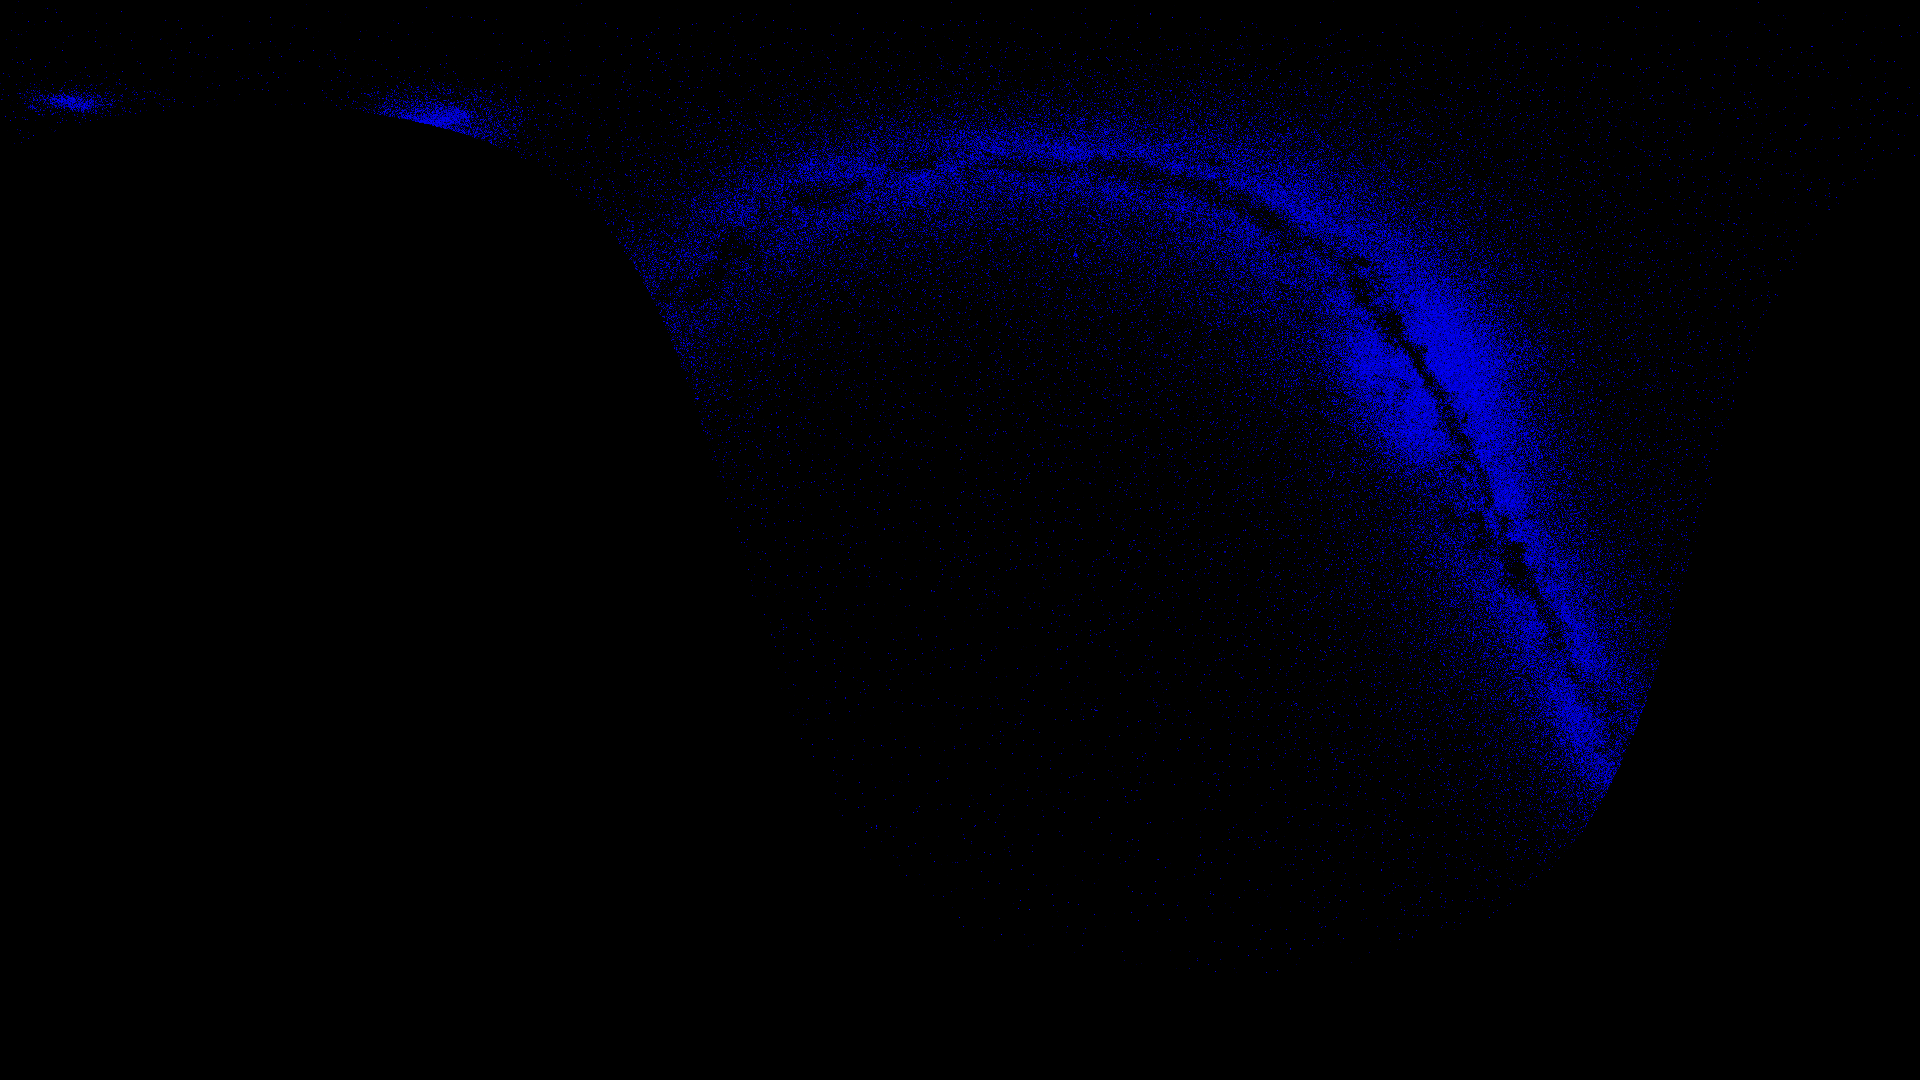

In [10]:
img

In [11]:
# Step 2: Transform coordinates
transformed_coords = adjust_coordinates_for_exoplanet(star_data, exo_ra, exo_dec)
star_data['ra']=transformed_coords.ra.deg
star_data['dec']=transformed_coords.dec.deg

In [12]:
new_d=adjust_distance(star_data, exo_ra, exo_dec, exo_d)
star_data['parralax_exo']=[dn/do if do!=0 else 0 for dn,do in zip(new_d,star_data['distance'],)]
star_data['phot_g_mean_mag_exo']=[p*(dn/do)**2 if do!=0 else 0 for dn,do,p in zip(new_d,star_data['distance'],star_data['phot_g_mean_mag'])]
star_data['difference']=[(do-dn) for dn,do in zip(new_d,star_data['distance'])]

In [13]:
# Make a plot of exo view
img=render_equirectangular(star_data, 'difference')
img.save('Images/exo.png')

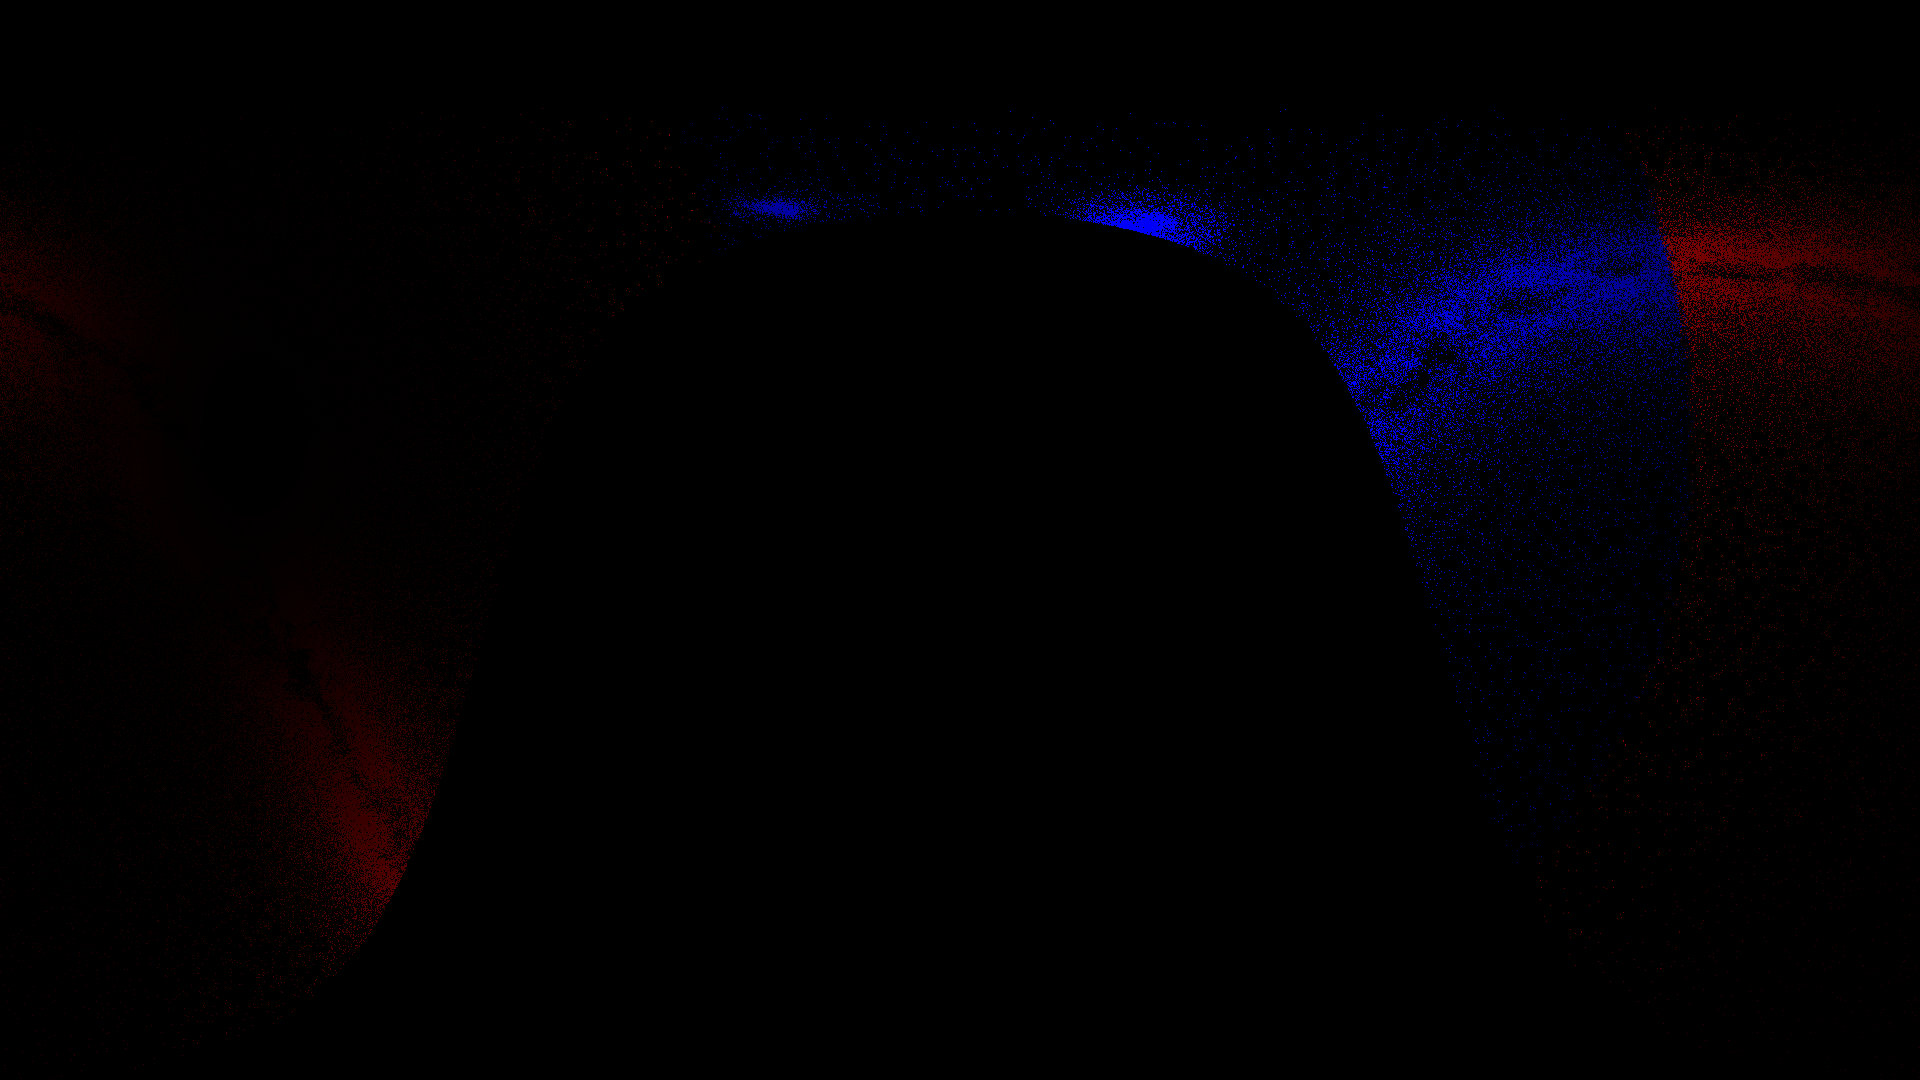

In [14]:
img